In [11]:
import os
import random
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# -------------------------
# Set random seed and device
# -------------------------
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------
# Model and training parameters
# -------------------------
max_steps = 20000
lr = 0.001
n_layers = 4
n_neurons = 100

# -------------------------
# Define the PINN model
# -------------------------
class PINN(nn.Module):
    def __init__(self, num_layers, num_neurons, input_dim=2, output_dim=2):
        super(PINN, self).__init__()
        self.input_layer = nn.Linear(input_dim, num_neurons)
        layers = []
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(num_neurons, num_neurons))
            layers.append(nn.Tanh())
        self.hidden_layers = nn.Sequential(*layers)
        self.output_layer = nn.Linear(num_neurons, output_dim)
        
    def forward(self, x):
        out = torch.tanh(self.input_layer(x))
        out = self.hidden_layers(out)
        return self.output_layer(out)

# -------------------------
# Create training data
# -------------------------
def create_data():
    # Domain bounds
    x_lower, x_upper = -5, 5
    t_lower, t_upper = 0, np.pi / 2
    
    # Initial Condition: t=0, x random in [x_lower, x_upper]
    n_ic = 100
    t_initial = np.zeros((n_ic, 1))
    x_initial = np.random.uniform(x_lower, x_upper, (n_ic, 1))
    initial_data = torch.from_numpy(np.hstack([t_initial, x_initial])).float().to(device)
    
    # Boundary Condition: x = x_lower and x_upper, t random in [t_lower, t_upper]
    n_bc = 100
    t_bc = np.random.uniform(t_lower, t_upper, (n_bc, 1))
    x_lower_bc = x_lower * np.ones((n_bc, 1))
    x_upper_bc = x_upper * np.ones((n_bc, 1))
    boundary_lower = torch.from_numpy(np.hstack([t_bc, x_lower_bc])).float().requires_grad_(True).to(device)
    boundary_upper = torch.from_numpy(np.hstack([t_bc, x_upper_bc])).float().requires_grad_(True).to(device)
    
    # PDE Collocation Points: uniformly sampled in the whole domain
    n_pde = 2000
    t_pde = np.random.uniform(t_lower, t_upper, (n_pde, 1))
    x_pde = np.random.uniform(x_lower, x_upper, (n_pde, 1))
    pde_data = torch.from_numpy(np.hstack([t_pde, x_pde])).float().requires_grad_(True).to(device)
    
    # For plotting the collocation points
    plot_data = {
        "x_initial": x_initial,
        "t_initial": t_initial,
        "t_bc": t_bc,
        "x_lower_bc": x_lower_bc,
        "x_upper_bc": x_upper_bc,
        "pde": np.hstack([t_pde, x_pde])
    }
    
    return pde_data, initial_data, boundary_lower, boundary_upper, plot_data

# -------------------------
# Utility: Compute gradients
# -------------------------
def gradients(output, inp):
    grad = torch.autograd.grad(
        outputs=output,
        inputs=inp,
        grad_outputs=torch.ones_like(output),
        create_graph=True
    )[0]
    return grad

# -------------------------
# Training function
# -------------------------
def train(model, pde_data, initial_data, boundary_lower, boundary_upper):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []
    
    for step in range(1, max_steps + 1):
        optimizer.zero_grad()
        
        # Initial Condition loss (t=0)
        output_ic = model(initial_data)
        # True initial condition: u(x,0)=2/cosh(x) (real) and 0 (imaginary)
        initial_true = 2 / torch.cosh(initial_data[:, 1:2])
        loss_ic = torch.mean((output_ic[:, 0:1] - initial_true)**2) + torch.mean((output_ic[:, 1:2])**2)
        
        # Boundary Condition loss (periodic in x)
        output_lower = model(boundary_lower)
        output_upper = model(boundary_upper)
        # Also enforce matching first derivatives at the boundaries
        grad_lower_real = gradients(output_lower[:, 0:1], boundary_lower)[:, 1:2]
        grad_upper_real = gradients(output_upper[:, 0:1], boundary_upper)[:, 1:2]
        grad_lower_imag = gradients(output_lower[:, 1:2], boundary_lower)[:, 1:2]
        grad_upper_imag = gradients(output_upper[:, 1:2], boundary_upper)[:, 1:2]
        loss_bc = (torch.mean((output_lower[:, 0:1] - output_upper[:, 0:1])**2) +
                   torch.mean((output_lower[:, 1:2] - output_upper[:, 1:2])**2) +
                   torch.mean((grad_lower_real - grad_upper_real)**2) +
                   torch.mean((grad_lower_imag - grad_upper_imag)**2))
        
        # PDE residual loss
        output_pde = model(pde_data)
        u_real = output_pde[:, 0:1]
        u_imag = output_pde[:, 1:2]
        
        # Compute time and space gradients
        grad_real = gradients(u_real, pde_data)
        dt_real = grad_real[:, 0:1]
        dx_real = grad_real[:, 1:2]
        
        grad_imag = gradients(u_imag, pde_data)
        dt_imag = grad_imag[:, 0:1]
        dx_imag = grad_imag[:, 1:2]
        
        # Second-order derivative in x
        dxx_real = gradients(dx_real, pde_data)[:, 1:2]
        dxx_imag = gradients(dx_imag, pde_data)[:, 1:2]
        
        # NLSE residual (split into real and imaginary parts)
        res_real = - dt_imag + 0.5 * dxx_real + (u_real**2 + u_imag**2) * u_real
        res_imag = dt_real + 0.5 * dxx_imag + (u_real**2 + u_imag**2) * u_imag
        loss_pde = torch.mean(res_real**2) + torch.mean(res_imag**2)
        
        loss = loss_ic + loss_bc + loss_pde
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        # print every 1000 steps
        if step % 1000 == 0:
            print(f"Step {step}/{max_steps}, Total Loss: {loss.item():.4e}, IC: {loss_ic.item():.4e}, BC: {loss_bc.item():.4e}, PDE: {loss_pde.item():.4e}")
        #print(f"Step {step}/{max_steps}, Total Loss: {loss.item():.4e}, IC: {loss_ic.item():.4e}, BC: {loss_bc.item():.4e}, PDE: {loss_pde.item():.4e}")
    
    # Plot training loss in log scale
    plt.figure()
    plt.plot(range(1, max_steps+1), losses)
    plt.yscale('log')
    plt.xlabel("Training Step")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.show()

# -------------------------
# Testing function: load .mat test data and plot predictions
# -------------------------
def test_and_plot_from_mat(model):
    # Change the file path as needed
    mat_file_path = r'C:\Users\cjklap\Desktop\MSc_Final_Project\MSc_Final_Project\Physics-Informed Neural Networks (PINNs)\Schrodinger Equation\NLS.mat'
    data = loadmat(mat_file_path)
    t_data = data['tt']   # shape assumed (N_t, 1) or (N_t,)
    x_data = data['x']    # shape assumed (N_x, 1) or (N_x,)
    Exact = data['uu']    # Exact solution, assumed shape (N_x, N_t)
    
    # Ensure t and x are 1-D vectors
    t_vec = t_data.flatten()
    x_vec = x_data.flatten()
    
    # Create meshgrid from provided test data
    T, X = np.meshgrid(t_vec, x_vec)
    # Stack to create test input; model expects [t, x]
    test_points = np.hstack([T.reshape(-1, 1), X.reshape(-1, 1)])
    test_tensor = torch.from_numpy(test_points).float().to(device)
    
    model.eval()
    with torch.no_grad():
        pred = model(test_tensor)
        # Compute magnitude of prediction (combine real & imaginary parts)
        pred_mag = torch.sqrt(pred[:, 0:1]**2 + pred[:, 1:2]**2)
        pred_mag = pred_mag.cpu().numpy().reshape(T.shape)
    
    # Plot predicted magnitude
    plt.figure()
    cp = plt.contourf(T, X, pred_mag, levels=50, cmap='viridis')
    plt.colorbar(cp)
    plt.xlabel("t")
    plt.ylabel("x")
    plt.title("Predicted Magnitude")
    plt.savefig('Predicted Magnitude.png')
    plt.show()
    
    # Plot exact solution magnitude
    plt.figure()
    cp = plt.contourf(T, X, np.abs(Exact), levels=50, cmap='viridis')
    plt.colorbar(cp)
    plt.xlabel("t")
    plt.ylabel("x")
    plt.title("Exact Magnitude")
    plt.savefig('Exact Magnitude.png')
    plt.show()
    
    # Plot absolute error between prediction and exact solution
    error = np.abs(pred_mag - np.abs(Exact))
    plt.figure()
    cp = plt.contourf(T, X, error, levels=50, cmap='viridis')
    plt.colorbar(cp)
    plt.xlabel("t")
    plt.ylabel("x")
    plt.title("Absolute Error")
    plt.show()

    # Plot some slices of the prediction and exact solution
    plt.figure()
    plt.plot(x_vec, pred_mag[:,0], label='Prediction (t=0)')
    plt.plot(x_vec, np.abs(Exact)[:, 0], label='Exact (t=0)', linestyle='dashed')  
    plt.xlabel("x")
    plt.ylabel("Magnitude")
    plt.title("t=0")
    plt.legend()
    plt.savefig('t=0.png')
    plt.show()

    plt.figure()
    plt.plot(x_vec, pred_mag[:, 50], label='Prediction (t=0.5)')
    plt.plot(x_vec, np.abs(Exact)[:, 50], label='Exact (t=0.5)', linestyle='dashed')
    plt.xlabel("x")
    plt.ylabel("Magnitude")
    plt.title("t=0.5")
    plt.legend()
    plt.savefig('t=0.5.png')
    plt.show()

    plt.figure()
    plt.plot(x_vec, pred_mag[:,100], label='Prediction (t=1)')
    plt.plot(x_vec, np.abs(Exact)[:, 100], label='Exact (t=1)', linestyle='dashed')
    plt.xlabel("x")
    plt.ylabel("Magnitude")
    plt.title("t=1")
    plt.legend()
    plt.savefig('t=1.png')
    plt.show()
    
    # Optionally, print error statistics
    l2_error = np.linalg.norm(error) / np.linalg.norm(np.abs(Exact))
    print(f"Relative L2 Error: {l2_error:.4e}")


In [ ]:

# -------------------------
# Main script
# -------------------------

    # Create training data and optionally plot collocation points
pde_data, initial_data, boundary_lower, boundary_upper, plot_data = create_data()

plt.figure(figsize=(6, 5))
plt.scatter(plot_data["x_initial"], plot_data["t_initial"], color='red', label='Initial')
plt.scatter(plot_data["x_lower_bc"], plot_data["t_bc"], color='blue', label='Boundary')
plt.scatter(plot_data["x_upper_bc"], plot_data["t_bc"], color='blue')
plt.scatter(plot_data["pde"][:, 1], plot_data["pde"][:, 0], color='green', s=10, label='PDE')
plt.xlabel("x")
plt.ylabel("t")
plt.title("Collocation Points")
plt.legend()
plt.show()

# Initialize and train the model
model = PINN(num_layers=n_layers, num_neurons=n_neurons).to(device)
print(model)
train(model, pde_data, initial_data, boundary_lower, boundary_upper)

# Test using the .mat file and plot results
test_and_plot_from_mat(model)


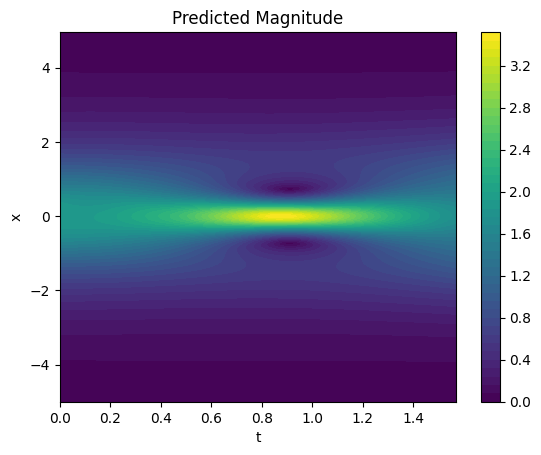

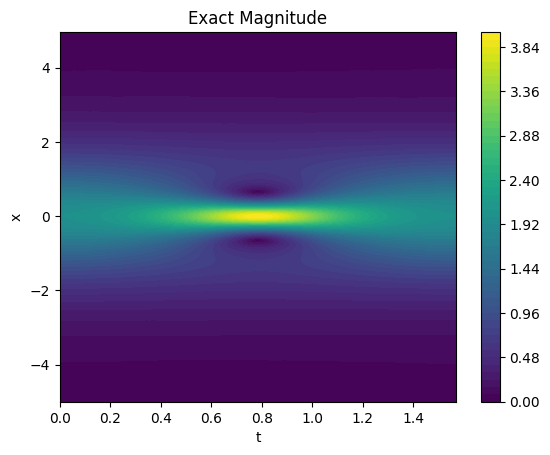

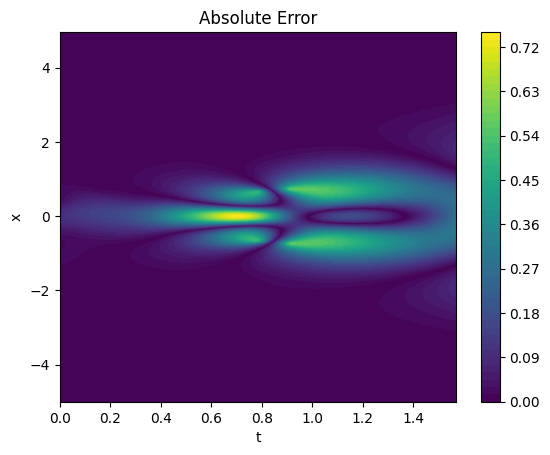

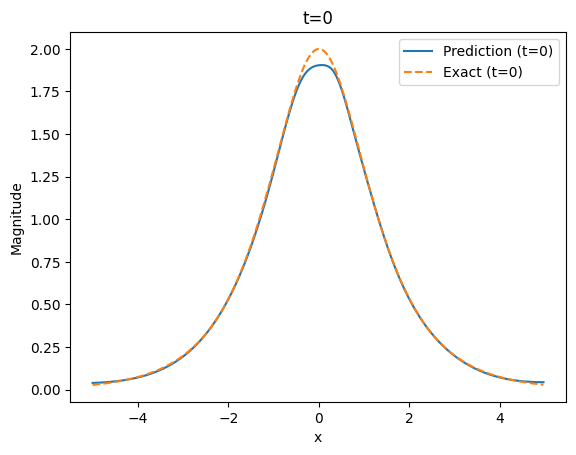

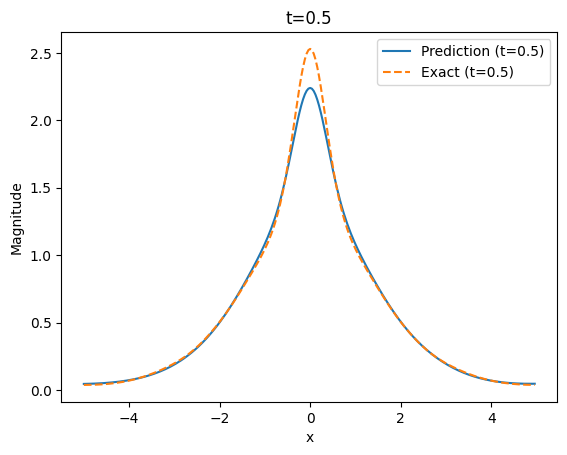

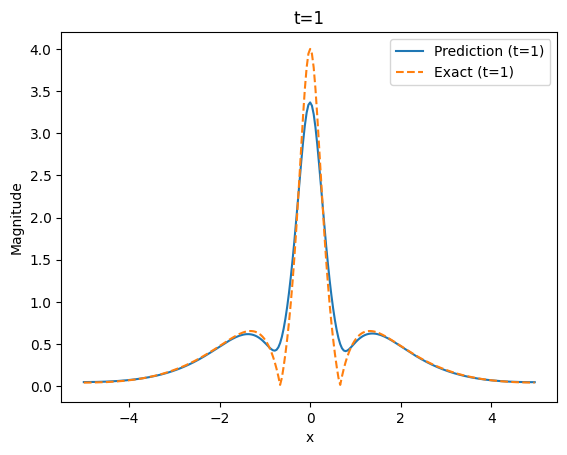

Relative L2 Error: 1.3308e-01


In [12]:
test_and_plot_from_mat(model)